# Data-Driven Music History

## Workshop at the *International Conference of Students of Systematic Musicology (SysMus)*

14 September 2020, 2-3:30 PM

Fabian C. Moss ([@fabianmoss](https://twitter.com/fabianmoss))<br />
Digital and Cognitive Musicology Lab<br />
École Polytechnique Fédérale de Lausanne

<img src="img/EPFL.png" width=200 align="left">
<img src="img/SNF.png" width=300 align="right">

**Abstract**

<p class="fragment fade-in">Traditionally, musicology has been divided into historical and systematic research agendas, encompassing qualitative-hermeneutic and quantitative-empirical methodologies, respectively. Innovations in the emerging and rapidly growing field of musical corpus studies question this fundamental divide and address, for instance, inherently historical questions with quantitative methods, fueled by the creation of ever larger and more appropriate datasets.</p>
<p class="fragment fade-in">
    This workshop first introduces some methodological and epistemological issues regarding empirical approaches to music history. It then presents a hands-on exercise on a case study. Finally, it invites critical discussion about the implications and relevance of the results for other subfields such as music psychology. In doing so, the workshop simulates (nearly) the entire life cycle of a research project, from an initial idea via selecting appropriate operationalisations and measures up to choosing suitable visualisations to communicate the results, e.g. in a research article or a blog post. At each point, participants will be invited to critically reflect the decisions taken. Along the way, more general methods for data analysis (e.g. data transformation, clustering, dimensionality reduction, and plotting) will be introduced. This is expected to benefit participants in a vast number of future projects.</p>

In [89]:
import pandas as pd # for working with tabular data
import matplotlib.pyplot as plt # for plotting
plt.style.use("fivethirtyeight") # select specific plotting style
import seaborn as sns; sns.set_context("talk")
from IPython.display import Audio

## Background

In [129]:
# audio test
Audio("audio/chopin.mp3")

## This workshop

### Who am I?

- Music and Mathematics Education (University of Cologne, Germany)
- MA Musicology (University for Music and Dance, Cologne, Germany)
- started PhD in Musicology at Technical University, Dresden, Germany
- finished PhD in Digital Humanities at École Polytechnique Fédérale de Lausanne, Switzerland

### Who are you?

**Selected quotes**

<p class="fragment fade-in">"I am interested in the intersection of music theory, music cognition, and linguistics."</p>
<p class="fragment fade-in">"I want to study more methods about dealing with data."</p>
<p class="fragment fade-in">"I am very interested in combining historic and systematic music research."</p>

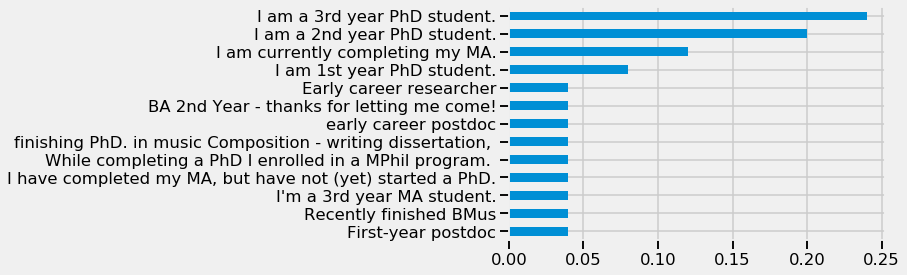

In [161]:
participants = pd.read_csv("data/participants.tsv", sep="\t")

status = participants["Please select the statement that applies to you."].value_counts(normalize=True, ascending=True)
status.plot(kind="barh")
plt.show()

## Technical aspects

* programming language: Python 3
* coding environment: Jupyter notebook
* less interactive than I'd like
* no prior programming experience necessary

We will see a lot of statements like

```python
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
```

For the purpose of this tutorial, it is not important that you understand each part of these `import` statements. It will be sufficient to understand why they are there. This will be explained in the commentary.

## Outline

#### Data

- Describe the raw data (e.g. source: musescore.com
- MusicXML (pros and cons)
- conversion to list of notes
- DataFrame representation in the [Tonal Pitch-Class Counts Corpus (TP3C)](https://github.com/DCMLab/TP3C)

Note: Data basis for computational music history still poor

| source | composers | pieces  |
|--------|-----------|---------|
| IMSLP  | 19,490    | 163,974 |
| RISM   | 1,242,773 | 38,500  |
| TP3C   | 2,012     | 75      |

- IMSLP, RILM not readily available for computational analysis
- Number of composers is less a problem than it seems: power-law, not uniform!
- still, the TP3C relatively small

## Musical pieces as tonal pitch-class distributions

In [162]:
note_names = list("FCGDAEB")
note_names

['F', 'C', 'G', 'D', 'A', 'E', 'B']

In [163]:
accidentals = ["bb", "b", "", "#", "##"]
accidentals

['bb', 'b', '', '#', '##']

In [164]:
tpcs = [ n + a for a in accidentals for n in note_names ]

tpcs

['Fbb',
 'Cbb',
 'Gbb',
 'Dbb',
 'Abb',
 'Ebb',
 'Bbb',
 'Fb',
 'Cb',
 'Gb',
 'Db',
 'Ab',
 'Eb',
 'Bb',
 'F',
 'C',
 'G',
 'D',
 'A',
 'E',
 'B',
 'F#',
 'C#',
 'G#',
 'D#',
 'A#',
 'E#',
 'B#',
 'F##',
 'C##',
 'G##',
 'D##',
 'A##',
 'E##',
 'B##']

In [165]:
import os # to perform system tasks

if not os.path.exists("data/data.tsv"):
    # create subdirectory
    !mkdir data
    
    # get data
    url = "https://raw.githubusercontent.com/DCMLab/TP3C/master/tpc_corpus.tsv"
    data = pd.read_csv(url, sep="\t")

    data.to_csv("data/data.tsv", sep="\t")

data = pd.read_csv("data/data.tsv", sep="\t", index_col=0)
data.head()

,composer,composer_first,work_group,work catalogue,opus,no,mov,title,composition,publication,...,A#,E#,B#,F##,C##,G##,D##,A##,E##,B##
0,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,1,NaN,Aime-moi,NaN,1837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,2,NaN,Le Vent,NaN,1837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,3,NaN,Morte,NaN,1837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alkan,Charles Valentin,Scherzi di bravoure,Op.,16,3,NaN,Etude de Bravour,NaN,1837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alkan,Charles Valentin,Étude de Concert,Op.,17,NaN,NaN,Le Preux,NaN,1844.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


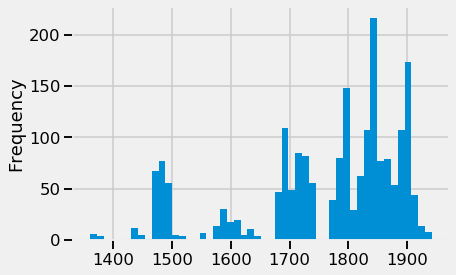

In [166]:
# historical overview
data.display_year.plot(kind="hist", bins=50);

In [167]:
# isolate tpc counts

tpc_counts = data.loc[:, tpcs]
tpc_counts.sample(20)

,Fbb,Cbb,Gbb,Dbb,Abb,Ebb,Bbb,Fb,Cb,Gb,...,A#,E#,B#,F##,C##,G##,D##,A##,E##,B##
1587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,12.0,...,427.0,259.0,78.0,54.0,28.0,1.0,0.0,0.0,0.0,0.0
697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,8.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We probably have very long pieces (sonatas) and very short pieces (songs) in the dataset. Since we don't want length (or the absolute number of notes in a piece) to have an effect, we rather consider tonal pitch-class distributions instead counts, by normalizing all pieces to sum to one.

In [168]:
tpc_dists = tpc_counts.div(tpc_counts.sum(axis=1), axis=0)
tpc_dists.sum(axis=1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
Length: 2012, dtype: float64

In [169]:
# extract values to matrix

X = tpc_dists.values
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Clustering

- pieces are points in 35D space
- similar pieces are close to each other
- clustering methods could reveal groups of similar pieces
  - how many clusters? 
  - interpretation of cluster? 
  - "discretizing" the space
- 35D is very complex. 
- We can use dimensionality reduction methods to get a visual impression of the structure induced by this pitch-class distributions of the pieces in this corpus

### Dimensionality reduction
#### Principle Component Analysis (PCA)

In [170]:
import numpy as np # for numerical computations
from sklearn.decomposition import PCA # for dimensionality reduction

dim = 35

pca = PCA(n_components=dim)
pca.fit(X)

x = np.arange(dim)
variance = pca.explained_variance_ratio_

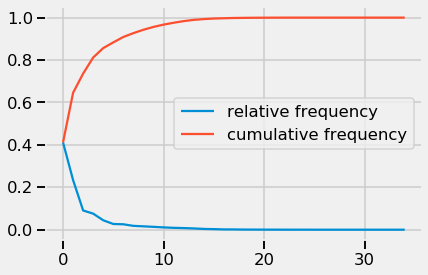

In [171]:
fig, ax = plt.subplots()
ax.plot(x, variance, label="relative frequency")
ax.plot(x, variance.cumsum(), label="cumulative frequency")

plt.legend()
plt.show()

If the number of components is equal to the dimensionality of the data, principal component analysis rotates the data such that it its principal components are aligned with the coordinate axes.

Apparently, the first principle component explains almost 40% of the variance of the data, the second explains 23% and the third 10%. Together, this amounts to 75%. 
In other words, considering only 3 instead of 35 dimensions still maintains 74% of the information!

Let us use this insight and use PCA to transform the data down from 35 to 3 dimensions ("dimensionality reduction").

In [172]:
pca3d = PCA(n_components=3)
pca3d.fit(X)

X_ = pca3d.transform(X)
X_.shape

(2012, 3)

In [173]:
data["tonal_center"] = data.apply(lambda x: np.argmax(x["Fbb":"B##"].values), axis=1)

In [174]:
from matplotlib import cm
from matplotlib.colors import Normalize

#normalize item number values to colormap
norm = Normalize(vmin=0, vmax=35)

cs = [ cm.seismic(norm(c)) for c in data["tonal_center"]]

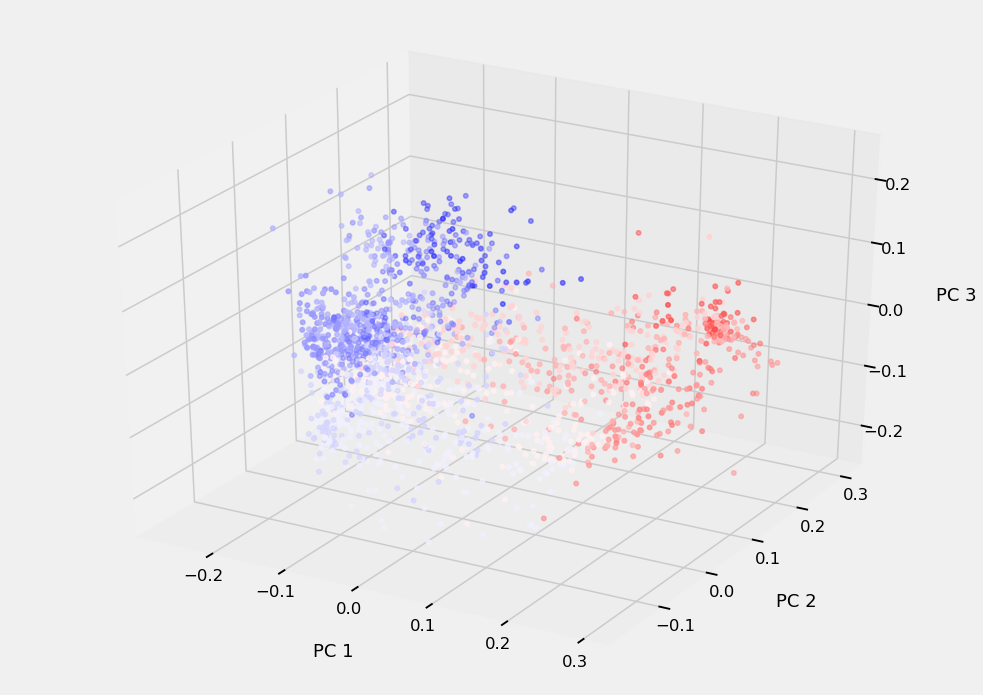

In [191]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_[:,0], X_[:,1], X_[:,2], c=cs)
ax.set_xlabel("PC 1", labelpad=30)
ax.set_ylabel("PC 2", labelpad=30)
ax.set_zlabel("PC 3", labelpad=30)

plt.tight_layout()
plt.show()

Each piece in this plot is represented by a point in 3D space. But remember that this location represents ~75% of the information contained in the full tonal pitch-class distribution.
In 35D space each dimension corresponded to the relative frequency of a tonal pitch-class in a piece.

- What do these three dimensions signify?
- How can we interpret them? 

Fortunately, we can inspect them individually and try to interpret what we see.

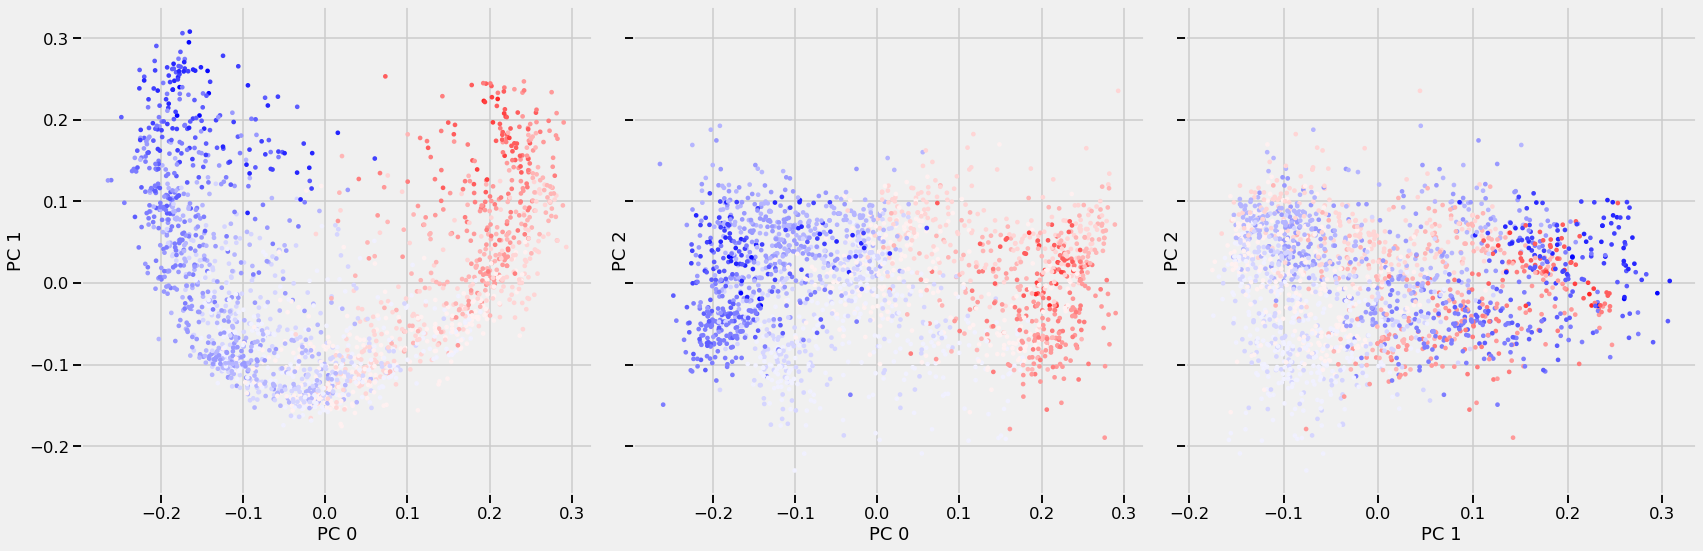

In [201]:
from itertools import combinations

fig, axes = plt.subplots(1,3, sharey=True, figsize=(24,8))

for k, (i, j) in enumerate(combinations(range(3), 2)):

    axes[k].scatter(X_[:,i], X_[:,j], s=10, c=[ np.abs(c) for c in cs])
    axes[k].set_xlabel(f"PC {i}")
    axes[k].set_ylabel(f"PC {j}")

plt.tight_layout()
plt.show()

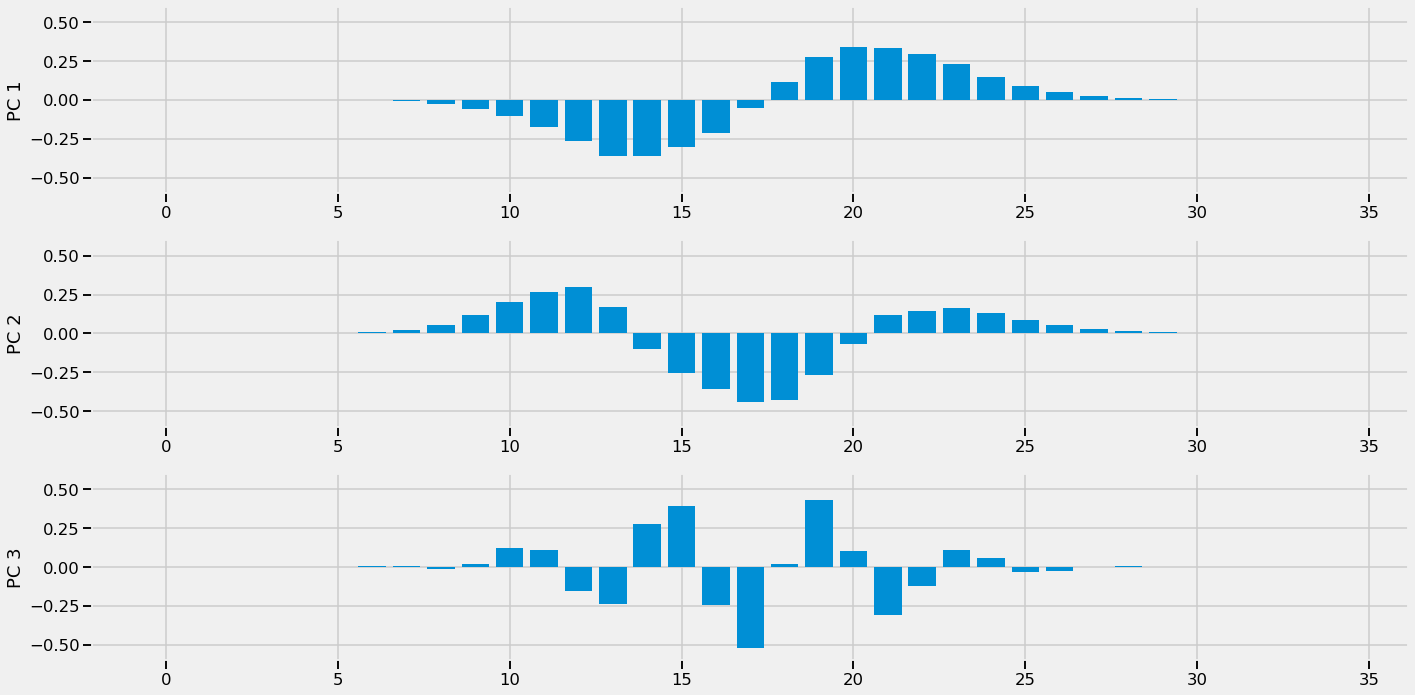

In [212]:
fig, axes = plt.subplots(3, figsize=(20,10))

for i in range(3):
    axes[i].bar(np.arange(35), pca.components_[i, :])
    axes[i].set_ylabel(f"PC {i + 1}")
    axes[i].set_ylim(-.6,.6)

plt.tight_layout()

It seems as if the first three (or maybe only two?) principal components contain a lot of structure. 
Recall that the tonal pitch-class counts in the original `data` were ordered along the line of fifths! Let us map the x-axis to the line of fifths.

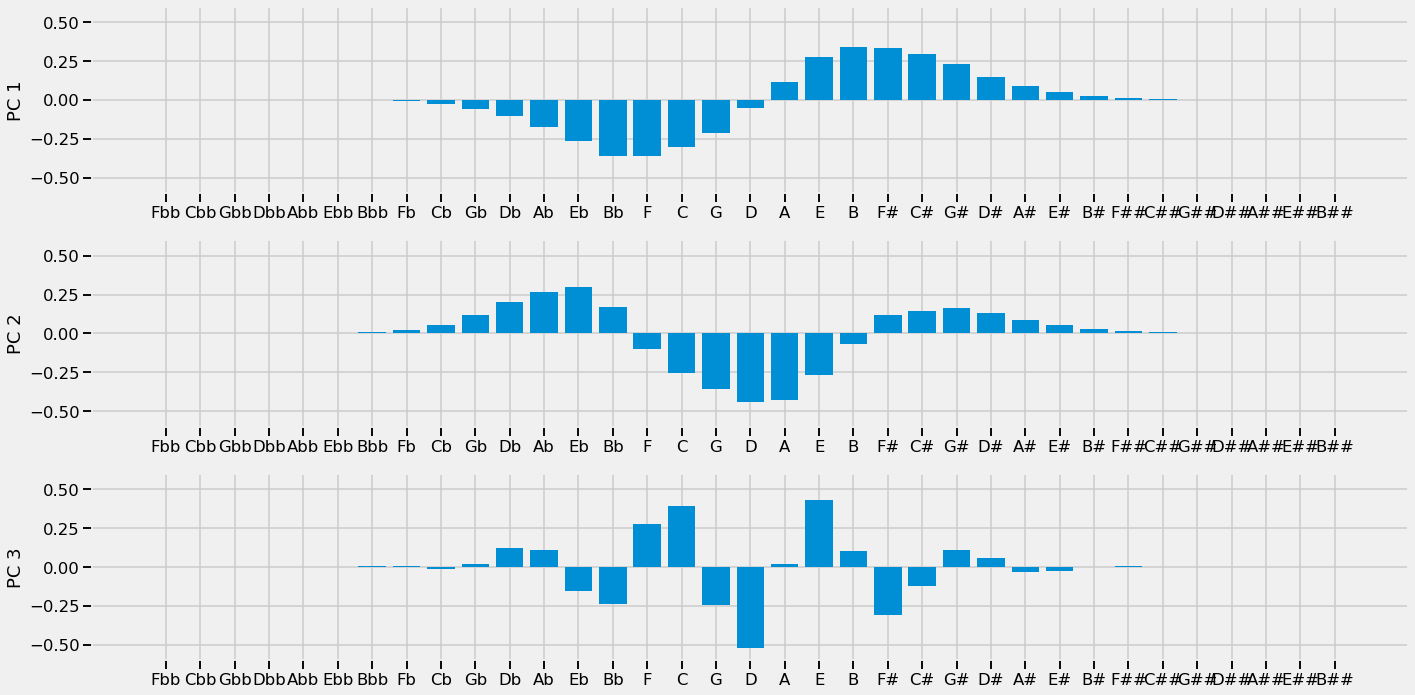

In [213]:
fig, axes = plt.subplots(3, figsize=(20,10))

for i in range(3):
    axes[i].bar(np.arange(35), pca.components_[i, :])
    axes[i].set_xticks(np.arange(35))
    axes[i].set_xticklabels(tpcs)
    axes[i].set_ylabel(f"PC {i + 1}")
    axes[i].set_ylim(-.6,.6)
    
plt.tight_layout()

This now allows for a very clear interpretation of the three first principal components:

1. The first component represents the two directions on the line of fifths: flatward (to the left) and sharpward (to the right).
2. The second component represents the number of accidentals: one flat/or sharp has positive values, no accidentals has negative values. More than that is probably so rare that it is not contained in the reduced space (lost information)
3. The third component is somewhat harder to interpet and appears to show a less clear picture. Let's focus on D. Similar values are shared by G (the perfect fifths below), Bb (the major third below), F# the major third above, and to a lesser degree Eb (the diatonic semitone above) and C# (the diatonic semitone below). Note that Db and D#, the enharmonic equivalents to NOT have high values!

Do the observations only hold for D? No, also for C! The fifth below (F) and the two major thirds (Ab, E), as well as the semitones (Db, B) exhibit the same pattern. 

- Note that the diatonic semitones are the perfect fifths to the major thirds! Here we see, in nucleo, a two-dimensional structure appearing, the *Tonnetz*.

In [214]:
from pitchplots.static import tonnetz

In [215]:
# tonnetz(pca.components_[2,:])

In [216]:
pca2d = PCA(n_components=2)
pca2d.fit(X)

X_ = pca2d.transform(X)
X_.shape

(2012, 2)

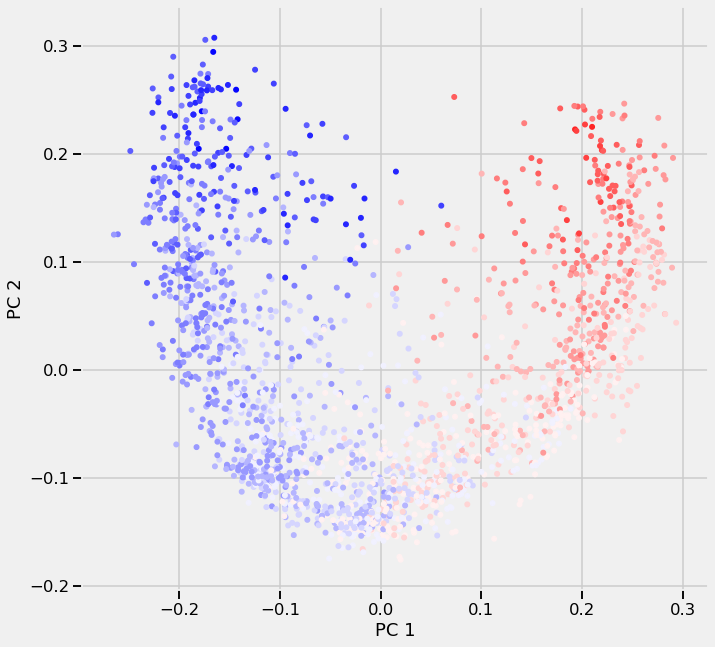

In [218]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.scatter(X_[:,0], X_[:,1], c=cs, s=20)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
plt.show()

### Historical development

We have established that tonal spaces (the line of fifths, the Tonnetz) are important underlying structures for pitch-class distributions in tonal compositions.
But we have treated all pieces in our dataset as synchronic and have not taken their historical location into account.

Let's look at random pieces on the line of fifths:

Text(0.5, 1.0, 'Schubert: nan')

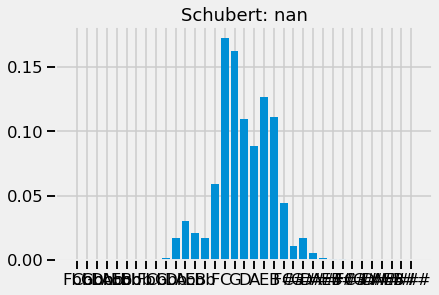

In [219]:
import random

rand = random.randint(0, 2012)

piece = tpc_dists.iloc[rand, :]

fig, ax = plt.subplots()
ax.bar(np.arange(35), piece)
ax.set_xticks(np.arange(35))
ax.set_xticklabels(tpcs)

ax.set_title(f"{data.loc[rand, 'composer']}: {data.loc[rand, 'title']}")

# ax.set_title(f"{composer}: {title}" for composer, title in data.loc[rand, ["composer", "title"]].values );

It is not too far fetched to say that virtually all pieces cluster together in a more or less narrow range on the line of fifths. But some spread wider than others. 
Let us use this observation and introduce a simple measure, the line-of-fifths range $r$ of a piece that is defined as the number of fifths between highest ("sharpest") and the lowest ("flattest") tonal pitch class that a piece contains. For example, a piece that only contains black notes (on the piano, and only spelled with either sharps of flats) has Bb as its sharpest and Gb as its flattest note. Accordingly, their range is 

$$ r = |lof(Bb) - lof(Gb)| = |-2 - (-6)| = 4$$

A piece that only contains black notes, spans five notes that are separated by four perfect fifths. This scale is called *pentatonic*.

We can not determine the lof-range for each piece in the corpus.

In [220]:
def lof_range(piece):
    l = [i for i, v in enumerate(piece) if v!=0]
    return max(l) - min(l)

In [221]:
lof_range(piece)

18

In [222]:
data["lof_range"] = data.loc[:, tpcs].apply(lof_range, axis=1)

In [223]:
data.sample(15)

,composer,composer_first,work_group,work catalogue,opus,no,mov,title,composition,publication,...,B#,F##,C##,G##,D##,A##,E##,B##,tonal_center,lof_range
598,Hensel,Fanny,Sechs Lieder,Op.,9,3,NaN,Der Rosenkranz,NaN,1850.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,10
745,Mozart,Wolfgang Amadeus,Sonaten,KV,309,7,2.0,NaN,1777.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,12
462,Chopin,Frédéric,Préludes,Op.,28,19,NaN,24 Préludes,1839.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,11
262,Beethoven,Ludwig van,Piano Sonatas,Op.,10,1,2.0,Piano Sonata No. 5,1798.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,11
983,Schumann,Robert,Liederkreis,Op.,39,6,NaN,Schöne Fremde,1840.0,1842.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,14
1747,Koželuh,Leopold,Piano Sonata,Op.,30,2,1,Allegro,1789.0,NaN,...,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,20,16
1384,Hummel,Johann Nepomuk,Preludes,Op.,67,14,NaN,Alla cappella,1815.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,21
1146,Henselt,Adolf von,Études Caracteristiques,Op.,2,2.0,NaN,"Pensez un peu à moi, qui pense toujours à vous",NaN,1838.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,19
447,Chopin,Frédéric,Préludes,Op.,28,4,NaN,24 Préludes,1839.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,9
1410,Victoria,TomasLuisde,NaN,NaN,NaN,NaN,NaN,Astiterunt reges,NaN,1585.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,12


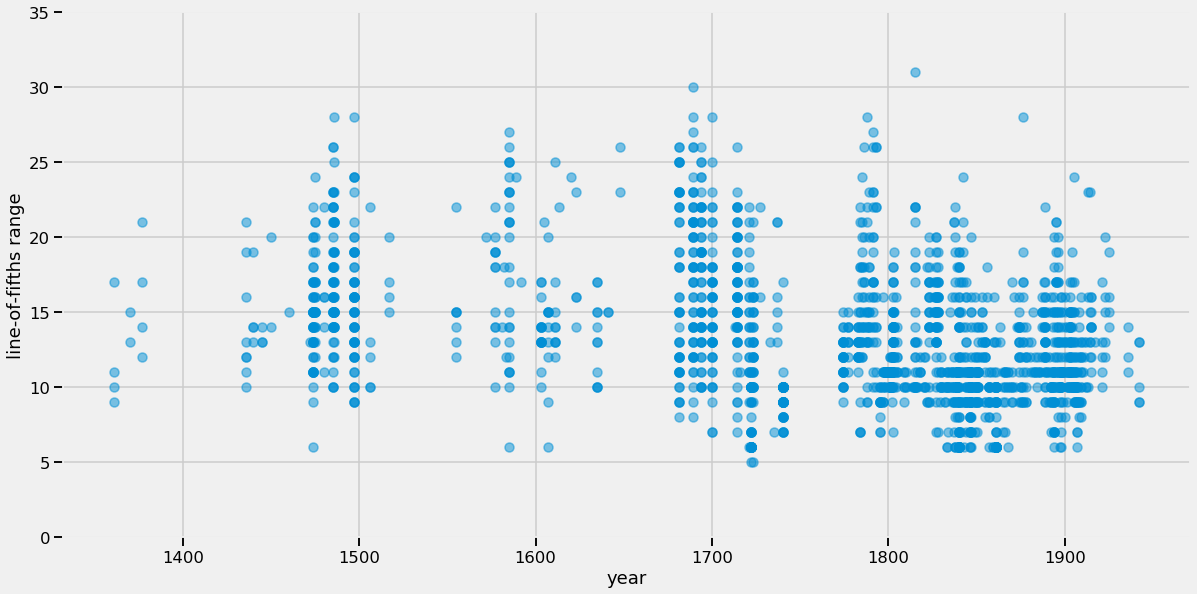

In [228]:
fig, ax = plt.subplots(figsize=(18,9))
ax.scatter(data["display_year"].values, data["lof_range"].values, alpha=.5)
ax.set_ylim(0,35)
ax.set_xlabel("year")
ax.set_ylabel("line-of-fifths range");

# METADATA IS SCRAMBLED!

#### Attention with single trendlines (--> models)
#### LOWESS curves

We use *Locally Weighted Scatterplot Smoothing* (LOWESS; Cleveland and Devlin, 1988) to
show historical trends in the distribution of fifths ranges. LOWESS fits a local polynomial
regression not to the entire dataset but to a neighborhood of each data point $x_0$ that is determined
by a fraction parameter defining what percentage of the whole data is taken into account
when calculating the regressions. The larger this fraction is the smoother the resulting lowess
curve will be. Here, this parameter was set to $\delta=.15$. Note that the range of years covered by
the neighborhood can vary, depending on how the data is distributed over time. In periods
with fewer pieces, a larger time range will be taken into account and vice versa. This is why the
lines are much smoother before ca. 1700 and show much more variability in later decades and
centuries. The weights for this regression are chosen so that they give less weight to data points
further away from $x_0$. A commonly used weighting function is the so-called tricube function,
$w(x_i) = (1 - |x_i - x_0|^3)^3$.

--> no need to decide for a specific polynomial. LOWESS locally fits polyninomials of different degrees

In [119]:
def tricube(x_range, x_0):
    return [ (1 - abs(x - x_0)**3)**3 for x in x_range ]

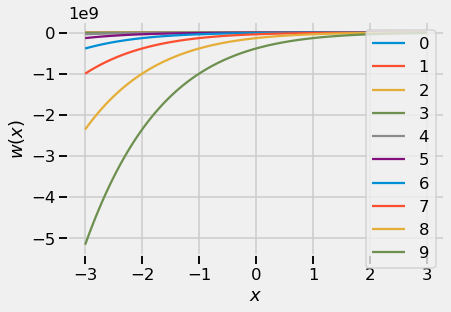

In [120]:
x_range = np.linspace(-3,3,100)

fig, ax = plt.subplots()

for x_0 in np.arange(0,10):
    ax.plot(x_range, tricube(x_range, x_0), label=f"{str(x_0)}")
    
ax.set_xlabel("$x$")
ax.set_ylabel("$w(x)$")
plt.legend()
plt.show()

#### Bootstrapping the data to estimate the variance

## Methodological considerations

## Acknowledgements

## Discussion